# Pattern Recognition 2019
## Lab Exercise 2
#### Christos Lamprakos, 03002910

### Step 1
First, ```praat``` was installed according to the exercise description. Files ```onetwothree1.wav``` and ```onetwothree8.wav``` were then read with the program. Below the respective waveforms and spectrograms are illustrated, along with the pitches and the formants. Selections of phonemes were taken for the requested measurements.

![1](./figs/1_spec.png)
![2](./figs/2_spec.png)

The following data were then collected:

- onetwothree1.wav (male speaker, top figure)
    - 'a' 
        - pitch: 134.9 Hz
        - 1st formant: 712.36 Hz
        - 2nd formant: 1094.14Hz
        - 3rd formant: 2213.3 Hz
    - 'ou' 
        - pitch: 129.3 Hz
        - 1st formant: 400.5 Hz
        - 2nd formant: 1761.8 Hz
        - 3rd formant: 2353.4 Hz
    - 'ee'
        - pitch: 130.9 Hz
        - 1st formant: 402.9 Hz
        - 2nd formant: 1862.3 Hz
        - 3rd formant: 2294 Hz

- onetwothree8.wav (female speaker, bottom figure)
    - 'a' 
        - pitch: 179.9 Hz
        - 1st formant: 798.5 Hz
        - 2nd formant: 1416.9 Hz
        - 3rd formant: 2842 Hz
    - 'ou' 
        - pitch: 187.7 Hz
        - 1st formant: 332.8 Hz
        - 2nd formant: 1740.4 Hz
        - 3rd formant: 2683.2 Hz
    - 'ee'
        - pitch: 179.7 Hz
        - 1st formant: 400.7 Hz
        - 2nd formant: 2137 Hz
        - 3rd formant: 2792.4 Hz
> ***ATTENTION:*** Based on [this][tut] tutorial, the maximum formants for the male and female speakers were set to 5000 and 5500 Hz respectively.

The male speaker's pitch is lower than the female's for all vowels. This can also be deduced from the higher oscillation rate in the female speaker's waveform.

In most of the cases, the difference between the 2 speakers' formants increases with the formant index. The second and third formants of the female speaker are higher than their male counterparts.

The segments corresponding to each vowel were not picked with a systematic way. Both the pitch and the formants depend on calculations which with their turn depend on parameters that were not configured (in any other way than ```praat```'s any automatic process). Thus the results should be taken with a grain of salt.

>***HYPOTHESIS:*** A machine learning approach could leverage the data itself in order to resolve accuracy problems due to lack of expertise. Theoretical knowledge as regards pitch, formants etc. would then be of value only during the **interpretation**, not the **extraction** of the results.

### Rest Steps Preamble
For the rest of the steps, ```python``` was used. The code cell below includes all related imports. Data was read with ```librosa``` and represented with ```numpy``` arrays, ```pytplot``` was used for visualization. The custom-made ```ToolConfig``` class is of mostly typical nature:

```python
class ToolConfig ():
    def __init__ (self):
        self.one = './data/onetwothree1.wav'
        self.two = './data/onetwothree8.wav'
        self.digits_path = './data/digits'
```

[tut]: <https://www.gouskova.com/2016/09/03/praat-tutorial/#Annotating_an_audio_file_with_TextGrids>

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from config import ToolConfig
from src import tool

conf = ToolConfig ()

Last but not least, before anything else, a loading and plotting of the alreadyshown waveforms was done with ```librosa```, just to ensure that all works well.

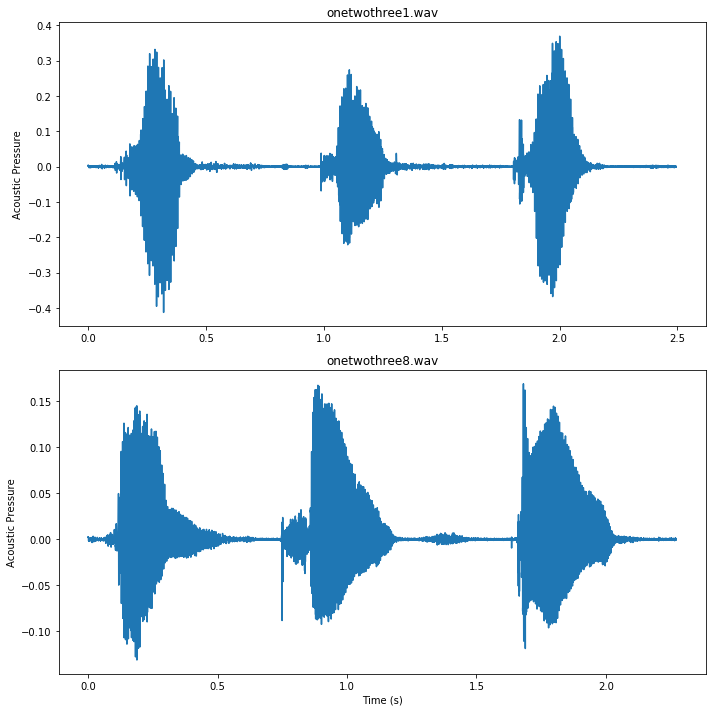

In [2]:
x, fr = librosa.load (conf.one)
x_time = np.linspace (0, (x.size - 1) / fr, x.size)
y, fr2 = librosa.load (conf.two)
y_time = np.linspace (0, (y.size - 1) / fr2, y.size)
fig = plt.figure (figsize = (10, 10))
ax1 = fig.add_subplot (211)
ax1.plot (x_time, x)
ax1.set_title ('onetwothree1.wav')
ax1.set_ylabel ('Acoustic Pressure')
ax2 = fig.add_subplot (212)
ax2.plot (y_time, y)
ax2.set_title ('onetwothree8.wav')
ax2.set_ylabel ('Acoustic Pressure')
ax2.set_xlabel ('Time (s)')
fig.tight_layout ()
plt.show ()

### Step 2
The following functions were implemented:

```python
def nameToFacts (fileName):
    """
    This function returns in int form the parsed results of sound
    files named like 'six2.wav'.
    """
    valText = fileName[:fileName.find ('.')]
    digIdx = valText.find ('1' or '2' or '3' or '4' or '5' or '6' \
                           or '7' or '8' or '9')
    digString = valText[:digIdx]
    speakNum = int (valText[digIdx:])
    return speakNum, {
                        'one' :     1,
                        'two' :     2,
                        'three' :   3,
                        'four' :    4,
                        'five' :    5,
                        'six' :     6,
                        'seven' :   7,
                        'eight' :   8,
                        'nine' :    9
                     }.get (digString)

def dataParser (path):
    """
    This function parses all files in the directory specified by
    the path input variable. It is assumed that all said files are
    valid .wav files.
    """
    waves = []
    rates = []
    digits = []
    speakers = []
    files = [f for f in listdir (path) if isfile (join (path, f))]
    for i in range (len (files)):
        #Keep both the signals themselves, and the sampling rates.
        sig, rate = librosa.load (join (path, files[i]))
        waves.append (sig)
        rates.append (rate)
        jspeak, jdig = nameToFacts (files [i])
        digits.append (jdig)
        speakers.append (jspeak)
    print ('Parsing complete! ', len (waves), ' files in total.')
    return waves, np.array (digits), np.array (speakers), rates
```

>All written functions are contained in the ```tool``` moodule of the ```src``` package submitted with this report

In [3]:
wavs, digits, speakers, rates = tool.dataParser (conf.digits_path)

Parsing complete!  133  files in total.


### Step 3

To compute the MFCC's, ```librosa.feature.mfcc``` was used. The important parameters here were ```sr``` (sampling rate), ```n_mfcc``` (number of features), ```win_length``` (length of window) and ```hop_length``` (overlap control).

Particularly as regards the overlap, ```hop_length``` controls the number of samples between adjacent Short Time Fourier Transforms of the signal. Thus, the requirements of the exercise description (window length, overlap) have to be translated in sample numbers.

Also,```librosa.feature.delta``` was used for the deltas.

In [4]:
feats = []
deltas = []
deltas2 = []

for i in range (len (wavs)):
    win = round (25e-3 * rates[i])
    hop = round (15e-3 * rates[i])
    feats.append (librosa.feature.mfcc (wavs[i], sr = rates[i], \
                          n_mfcc = 13, win_length = win, hop_length = hop))
    deltas.append (librosa.feature.delta (feats[i]))
    deltas2.append (librosa.feature.delta (feats[i], order = 2))

Now the features for all of the sound files are saved in the lists above. Note that on the one hand, using lists is not so efficient, but the different signal sizes do not leave us with amore flexible choice.

### Step 4
Due to the large number of figures, a wrapping function for the histogram plotting was written:

```python
def histPlotter (n1, feature, feats, digits, speakers):
    """
    This function draws the histograms of a certain feature of
    a certain digit across all speakers.
    """
    fig = plt.figure (figsize = (8, 8))
    fig_idx = 1
    for i in range (digits.size):
        if digits[i] == n1:
            ax = fig.add_subplot (4, 4, fig_idx)
            ax.hist (feats[i][feature - 1, :])
            ax.set_title ('Speaker ' + str (speakers[i]))
            fig_idx += 1
    fig.tight_layout ()
    plt.show ()
```
The function was then called sequentially in order to provide the requested output. First, for the first feature of digit 1:

>My student number is 03002910, which translates to n1 = 1, n2 = 2

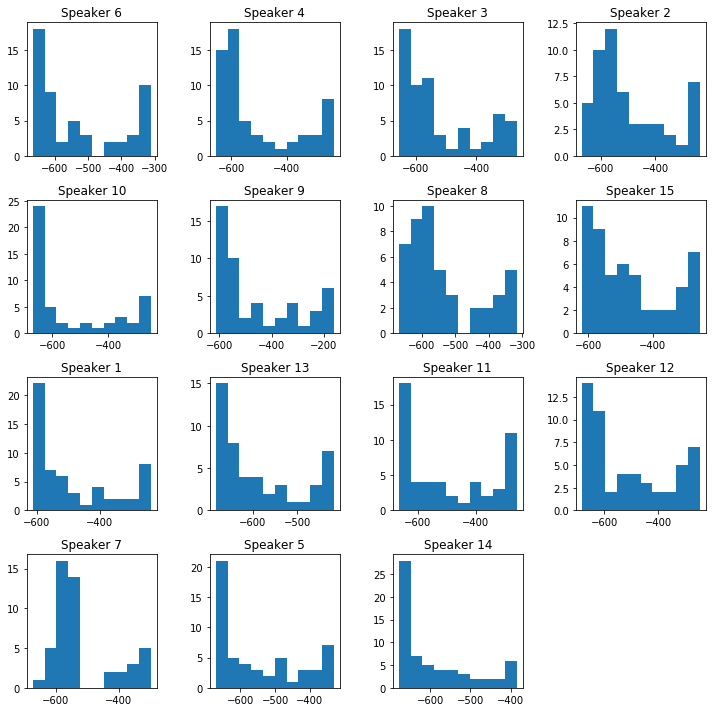

In [5]:
tool.histPlotter (1, 1, feats, digits, speakers)   

Then, for the second feature of digit 1:

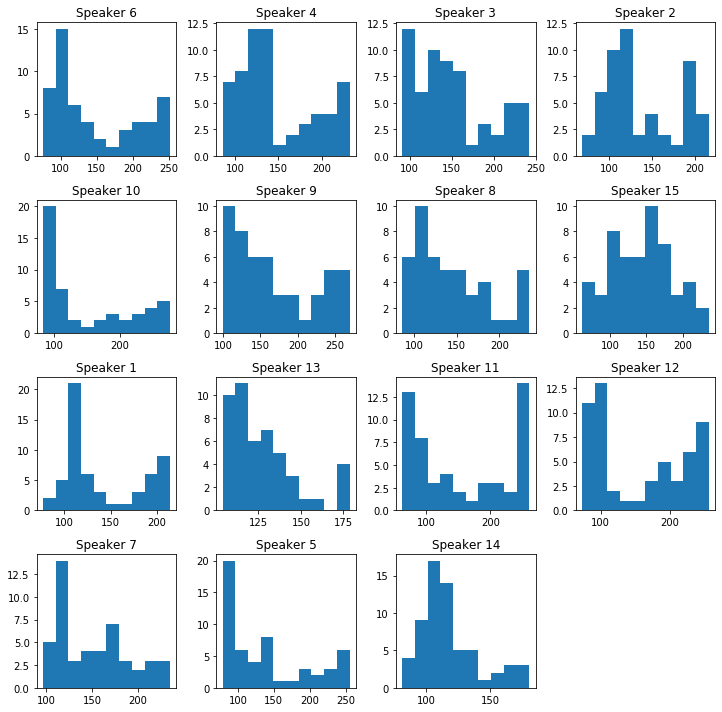

In [6]:
tool.histPlotter (1, 2, feats, digits, speakers) 

Then, for the first feature of digit 2:

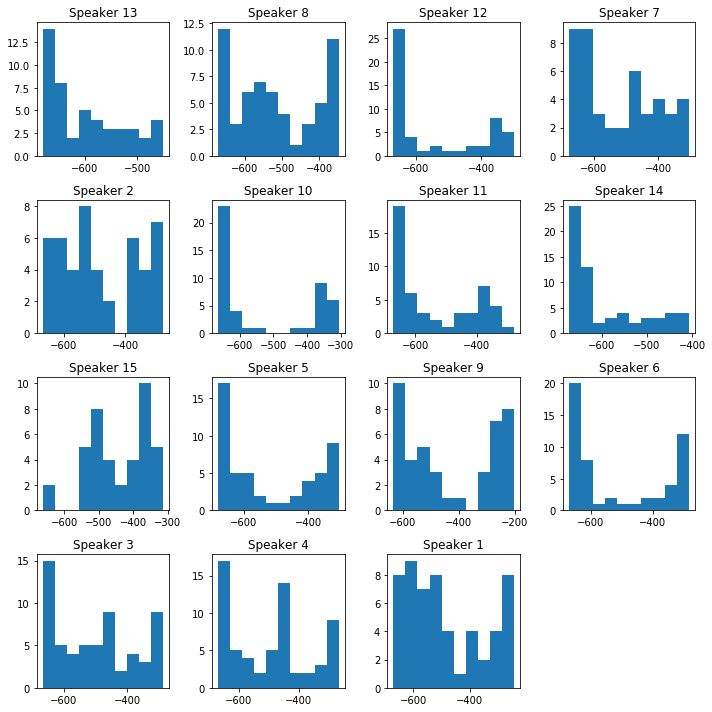

In [7]:
tool.histPlotter (2, 1, feats, digits, speakers) 

And finally, for 2's second feature:

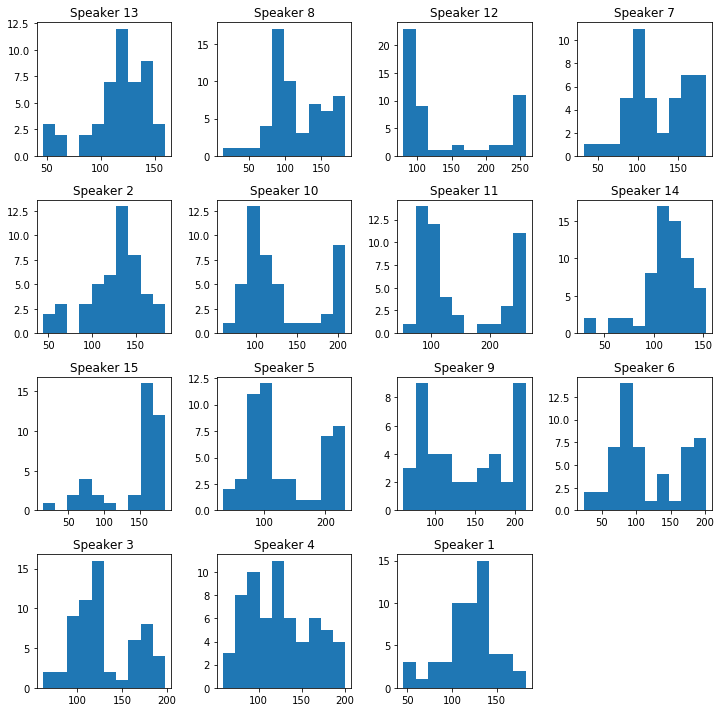

In [8]:
tool.histPlotter (2, 2, feats, digits, speakers) 

None of the above histogram groups seems to have identifiable patterns. This is natural, since the data are sequential and their temporal nature is lost with these visualizations.